<font size = "5"> **Chapter 3: [Imaging](CH3_00-Imaging.ipynb)** </font>


<hr style="height:1px;border-top:4px solid #FF8200" />



# Defocus-Thickness Map with Multislice Algorithm


[Download](https://raw.githubusercontent.com/gduscher/MSE672-Introduction-to-TEM/main/Imaging/CH3_05-Defocus_Thickness.ipynb)
 
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/gduscher/MSE672-Introduction-to-TEM/blob/main/Imaging/CH3_05-Defocus_Thickness.ipynb)


part of 

<font size = "5"> **[MSE672:  Introduction to Transmission Electron Microscopy](../_MSE672_Intro_TEM.ipynb)**</font>

by Gerd Duscher, Spring 2021

Microscopy Facilities<br>
Joint Institute of Advanced Materials<br>
Materials Science & Engineering<br>
The University of Tennessee, Knoxville

Background and methods to analysis and quantification of data acquired with transmission electron microscopes.



## Load important packages

### Check Installed Packages

In [43]:
import sys
from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = get_distribution(package_name).version
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version

# Colab setup ------------------
if 'google.colab' in sys.modules:
    !pip install pyTEMlib -q
# pyTEMlib setup ------------------
else:
    if test_package('pyTEMlib') < '0.2021.1.9':
        print('installing pyTEMlib')
        !{sys.executable} -m pip install  --upgrade pyTEMlib -q
# ------------------------------
print('done')

done


### Load Packages
We will use 
- numpy and matplotlib (installed with magic comand **%pylab**.)
- physical constants from scipy
- The pyTEMlib kinematic scattering librarty is only used to determine the wavelength.

In [1]:
# import matplotlib and numpy
#                       use "inline" instead of "notebook" for non-interactive plots
import sys
if 'google.colab' in sys.modules:
    %pylab --no-import-all inline
else:    
    %pylab --no-import-all notebook
    
import warnings
warnings.filterwarnings('ignore')


from mpl_toolkits.axes_grid1 import ImageGrid


# Import libraries from the book
import pyTEMlib
import pyTEMlib.kinematic_scattering as ks
import pyTEMlib.dynamic_scattering as ds

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)

__notebook__ = 'CH3-04-Linear_Image_Approximation'
__notebook_version__ = '2021_03_17'

Populating the interactive namespace from numpy and matplotlib
Using kinematic_scattering library version  0.6  by G.Duscher
spglib not installed; Symmetry functions of spglib disabled
pyTEM version:  0.2021.03.18



## Multislice Algorithm

As in the Dynamic Diffraction part in the [Multislice notebook](../Diffraction/CH2_D02-Multislice.ipynb), we first define the potential of the slices.

Here we make a SrTiO$_3$ crystal again

0 Sr [0. 0. 0.]
1 Ti [32. 32. 32.]
2 O [32.  0. 32.]
3 O [32. 32.  0.]
4 O [ 0. 32. 32.]
Sr
O
Ti
O


<IPython.core.display.Javascript object>


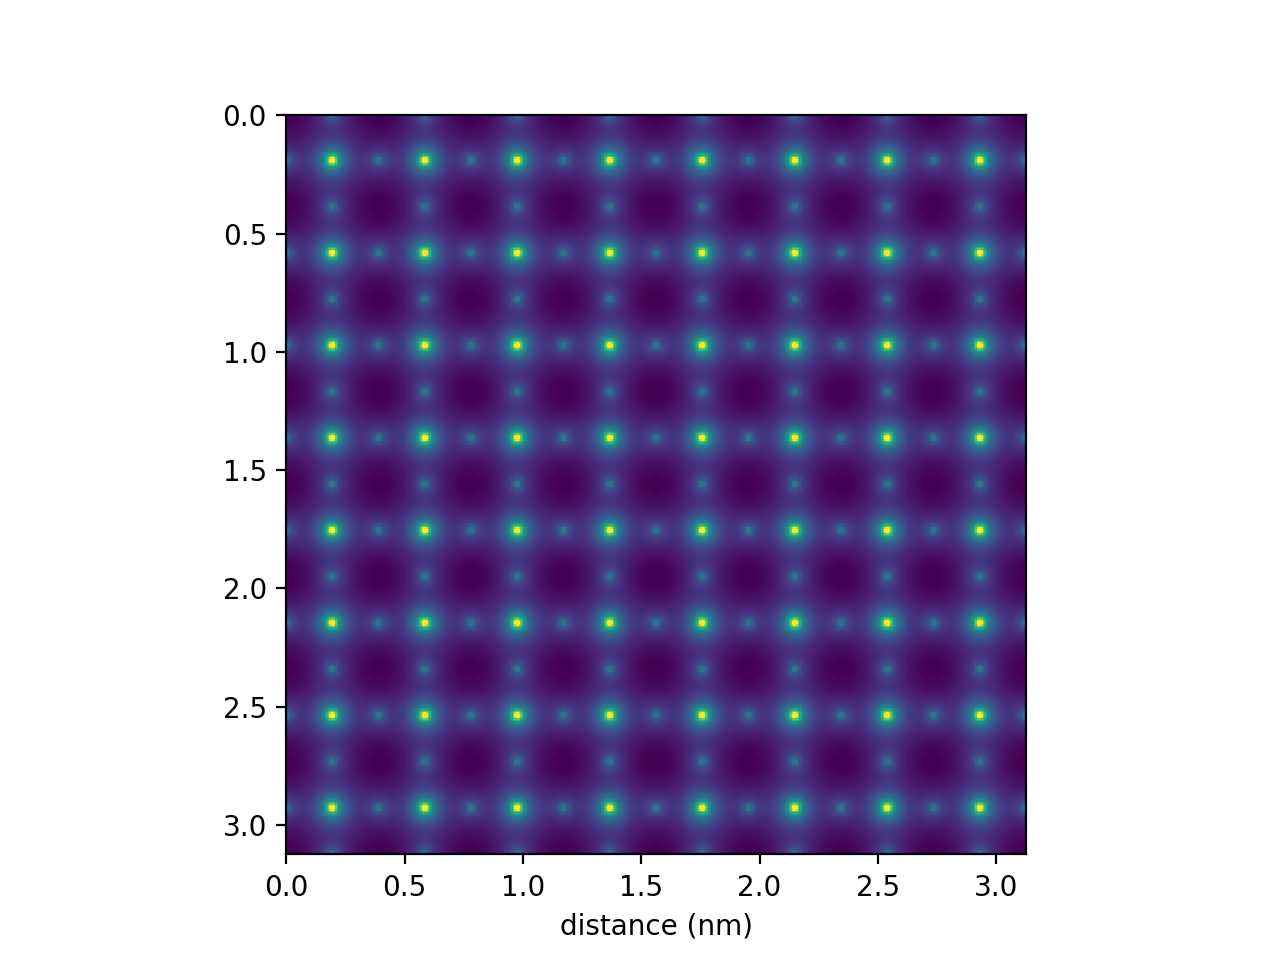

67.48663942120787


Text(0.5, 0, 'distance (nm)')

In [2]:
tags = ks.structure_by_name('SrTiO3')
size_in_pixel = nx = ny = 512
n_cell_x = 8
lattice_parameter = a = tags['unit_cell'][0,0]

pixel_size = a/(nx/n_cell_x)

positions = np.dot(tags['base'], tags['unit_cell'])  # in pixel
for i in range(len(tags['base'])):
    print(i, tags['elements'][i], positions[i]/ pixel_size)
layers = {}
layers[0] ={0:{'element': 'Sr', 'base': [tags['base'][0, 0:2]]}, 
            1:{'element': 'O',  'base': [tags['base'][3, 0:2]]}}
layers[1] ={0:{'element': 'Ti', 'base': [tags['base'][1, 0:2]]}, 
            1:{'element': 'O',  'base': tags['base'][[2,4], 0:2]}} 


image_extent = [0, size_in_pixel*pixel_size, size_in_pixel*pixel_size,0]
slice_potentials = np.zeros([2,nx,ny])
for layer in layers:
    for atom in layers[layer]:
        elem = layers[layer][atom]['element']
        print(elem)
        pos = layers[layer][atom]['base']
        for pos in unit_cell_base:
        potential = potential + np.roll(atom_potential_corner, shift=np.array(pos), axis = [0,1])
    
        slice_potentials[layer] += ds.potential_2dim(elem, nx, nx, n_cell_x, n_cell_x, a, pos)
plt.figure()
#plt.imshow(layer_potentials.sum(axis=0))
print(slice_potentials.max())
plt.imshow(slice_potentials[1], extent = image_extent)
plt.xlabel('distance (nm)')


## Transmission Function for Very Thin Specimen

For a very thin specimen the ``weak phase approximation`` is the simples way to calculate a high resolution (phase contrast) image.  
In that approximation, the sample causes only a phase change to the incident plane wave.


To retrieve the exit we just multiply the transmission function $t(\vec{x})$ with the plane wave $\exp (2\pi i k_z z)$

$$ \Psi_t(\vec{x}) = t(\vec{x}) \exp \left(2 \pi i k_z z \right) \approx t(\vec{x})  $$

The specimen transmission function depends on the projected potential $v_z(\vec{x})$ and the interaction parameter $\sigma$:
$$t(\vec{x}) =  \exp \left( i \sigma v_z(\vec{x})\right)$$

with the interaction parameter $\sigma$:
$$ 
\sigma = \frac{2 \pi}{\lambda V} \left(  \frac{m_0 c^2 + eV}{2m_0c^2+eV} \right) = \frac{2 \pi m  e_0 \lambda}{h^2}
$$
with $ m = \gamma m_0$ and $eV$ the incident electron energy.

<IPython.core.display.Javascript object>


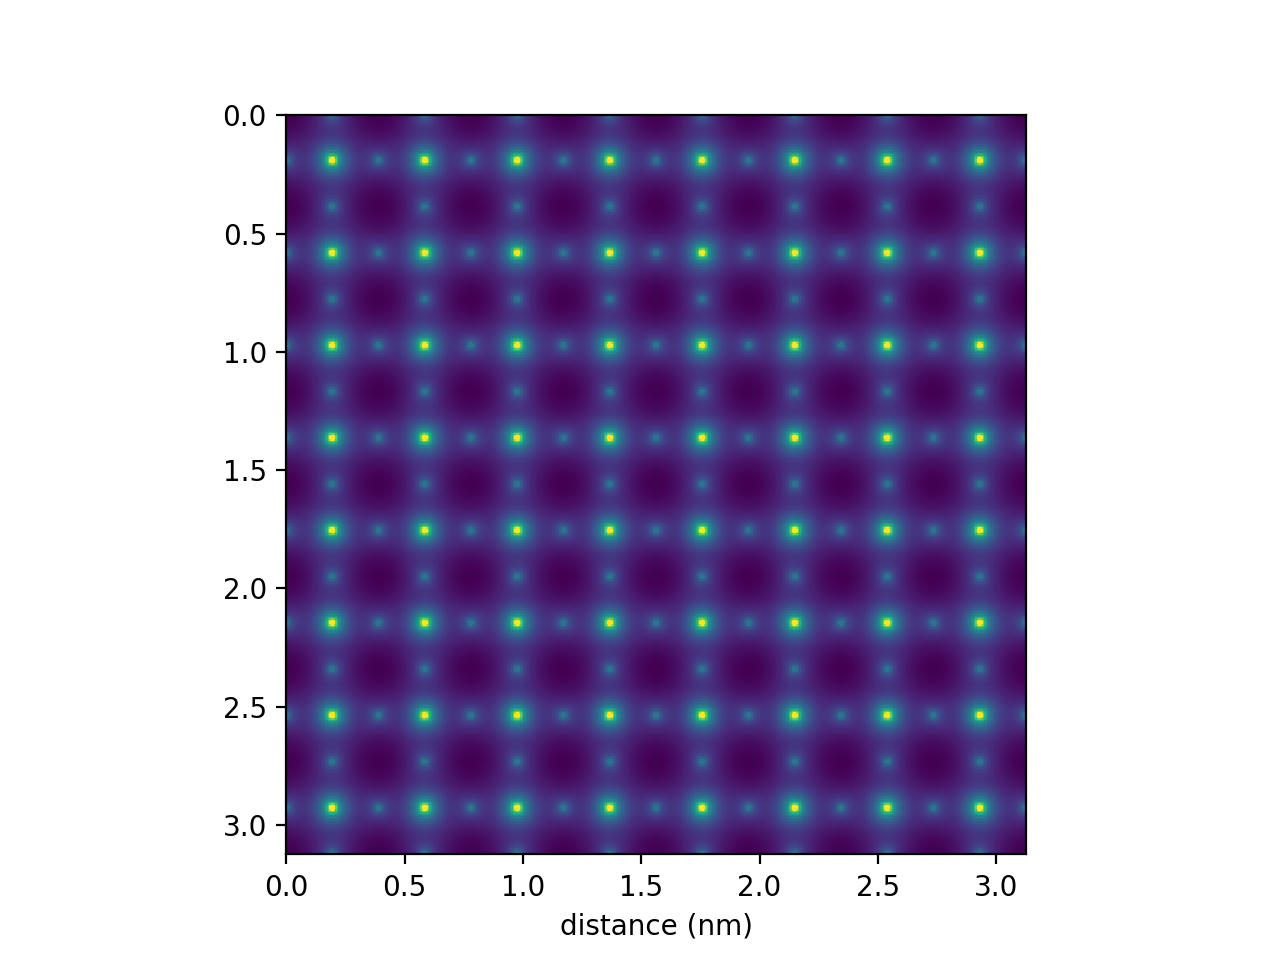

Text(0.5, 0, 'distance (nm)')

In [3]:
acceleration_voltage = 200000

transmission = ds.get_transmission(slice_potentials, acceleration_voltage)

plt.figure()
plt.imshow(transmission[1].imag, extent = image_extent)
plt.xlabel('distance (nm)')



## Step 4: Propagator
The Fresnel propagator $p$ propagates the wave through the vacuum of the layers between the (flat) atom potentials.
$$
p(x,y, \Delta z) = \mathcal{F} P(k_x, k_y, \Delta z)
$$
Mathematically, this propagator function has to be  convoluted with the wave, which is a multiplication in Fourier space $\mathcal{F}$.

$$
P(k,\Delta z) = \exp(-i\pi \lambda k^2 \Delta z)
$$

The Fourier space is limited in reciprocal vector to avoid aliasing. We realize that with  an aperture function.

Here we assume a cubic crystal and equidistant layers, but that of course is not always true.

[0.1952634, 0.1952634]
54.62706614074458
Bandwidth limited to a real space resolution of 18.30594375 pm
   (= 89.80 mrad)  for symmetrical anti-aliasing.
Number of symmetrical non-aliasing beams = 91528


<IPython.core.display.Javascript object>


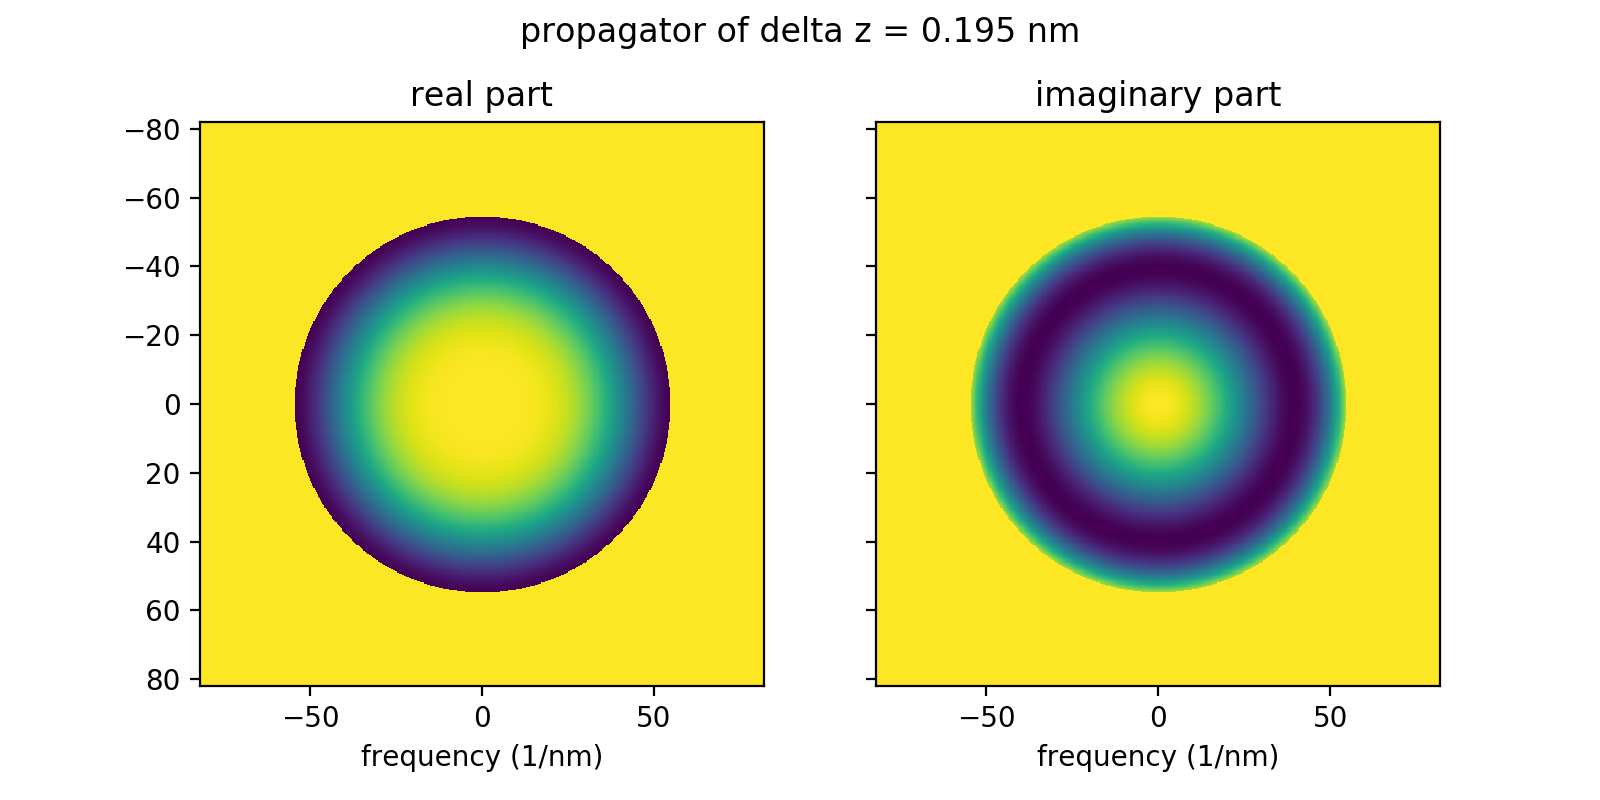

In [4]:
lattice_parameter = tags['unit_cell'][0,0]
field_of_view = 8 * lattice_parameter
size_in_pixel = 512
number_layers = 2
delta_z = [tags['unit_cell'][2,2]/number_layers, tags['unit_cell'][2,2]/number_layers]
print(delta_z)
wavelength = ks.get_wavelength(400000)
bandwidth_factor = 2/3   # Antialiasing bandwidth limit factor


propagator = ds.get_propagator(size_in_pixel, delta_z, number_layers, wavelength, field_of_view, 
                             bandwidth_factor, verbose=True)


recip_FOV = size_in_pixel/field_of_view/2.
reciprocal_extent = [-recip_FOV,recip_FOV,recip_FOV,-recip_FOV]
layer = 0
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
fig.suptitle(f"propagator of delta z = {delta_z[layer]:.3f} nm")
ax[0].set_title(f"real part")
ax[0].imshow(propagator[0].real,extent=reciprocal_extent)
ax[0].set_xlabel('frequency (1/nm)')
ax[1].set_title(f"imaginary part")
ax[1].set_xlabel('frequency (1/nm)')
ax[1].imshow(propagator[0].imag,extent=reciprocal_extent)


## Step 6: Multislice Loop

Combining the transmission function $t$ and the Frensel propagator $p$ we get
for each slice:
$$
\Psi(x,y,z+\Delta z) = p(x,y,\Delta z) \otimes \left[t(x,y,z)\Psi(x,y,z) \right] + \mathcal{O}(\Delta z^2)
$$

or an expression that bettere relfects the iterative nature of this equation for starting layer n :

$$
\Psi_{n+1}(x,y,) = p_n(x,y,\Delta z) \otimes \left[t_n(x,y,z)\Psi_n(x,y,z) \right] + \mathcal{O}(\Delta z^2)
$$

Again the convolution $\otimes$ will be done as a multiplication in Fourier space.

simulated SrTiO3 for thickness 3.124 nm


<IPython.core.display.Javascript object>


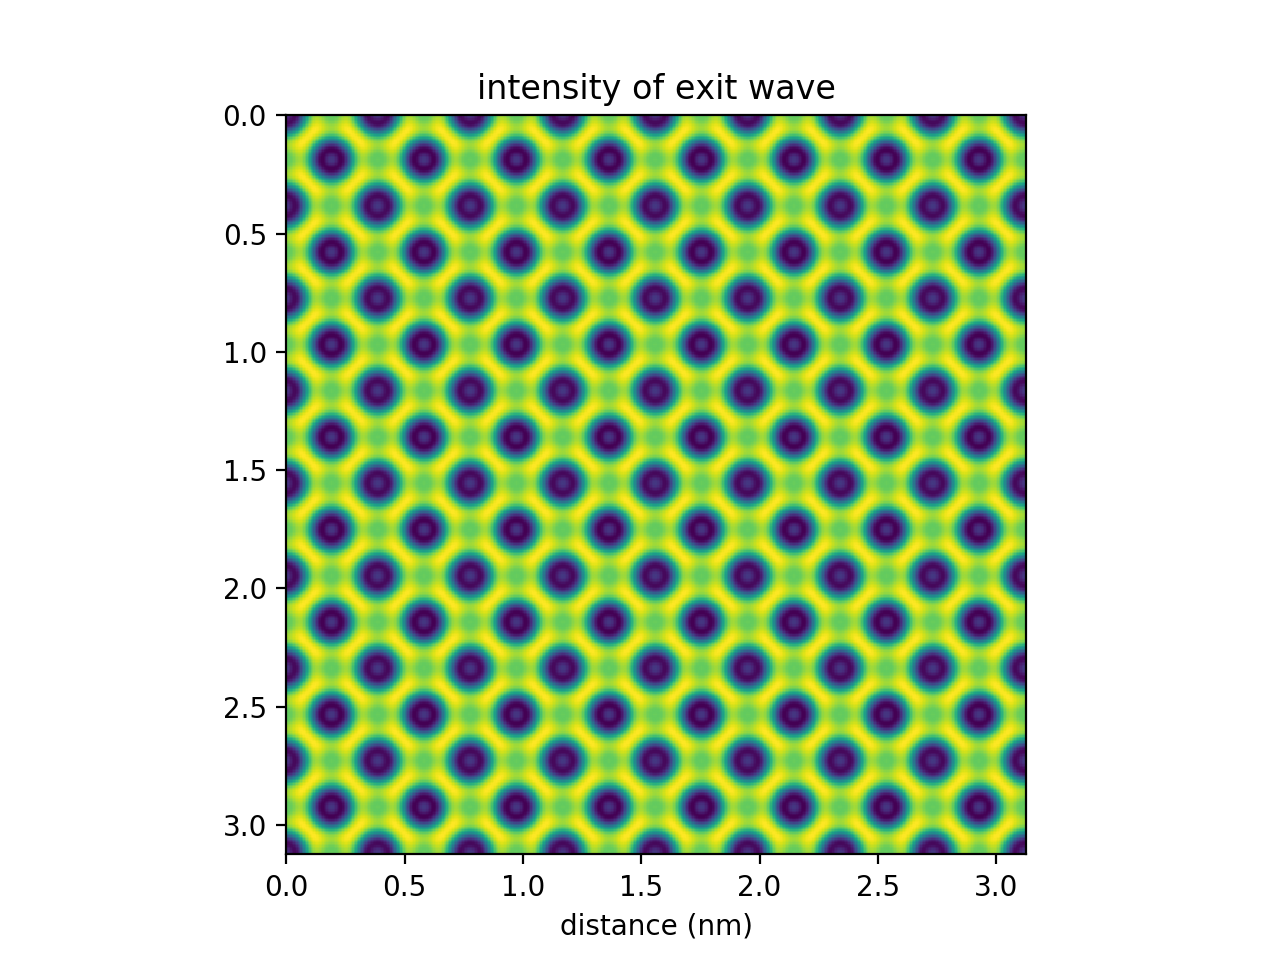

In [5]:
# ------Input------------- #
number_of_unit_cell_z = 8 # this will give us the thickness
# ------------------------ #    

def multi_slice(wave, number_of_unit_cell_z,  number_layers, transmission, propagator):
    """Multislice Calculation
    
    One the array wave will be changed
    """
    for i in range(number_of_unit_cell_z):
        for layer in range(number_layers): 
            wave = wave * transmission[layer] # transmission  - real space
            wave = np.fft.fft2(wave)
            wave = wave * propagator[layer]  # propagation; propagator is defined in reciprocal space
            wave = np.fft.ifft2(wave) #back to real space
    return wave

plane_wave = np.ones([size_in_pixel,size_in_pixel], dtype=complex)

exit_wave = ds.multi_slice(plane_wave, number_of_unit_cell_z, number_layers, transmission, propagator)
    
print(f"simulated {tags['crystal_name']} for thickness {number_of_unit_cell_z*tags['unit_cell'][0,0]:.3f} nm")

wave = np.fft.fft2(exit_wave)
intensity = np.abs(np.fft.fftshift(np.fft.ifft2(wave*wave)))

plt.figure()
plt.title('intensity of exit wave')
plt.imshow(intensity, extent = image_extent)
plt.xlabel('distance (nm)');

## Aberration Function

We make the aberration function like in the [Contrast Transfer notebook](CH3_03-CTF.ipynb)

<IPython.core.display.Javascript object>


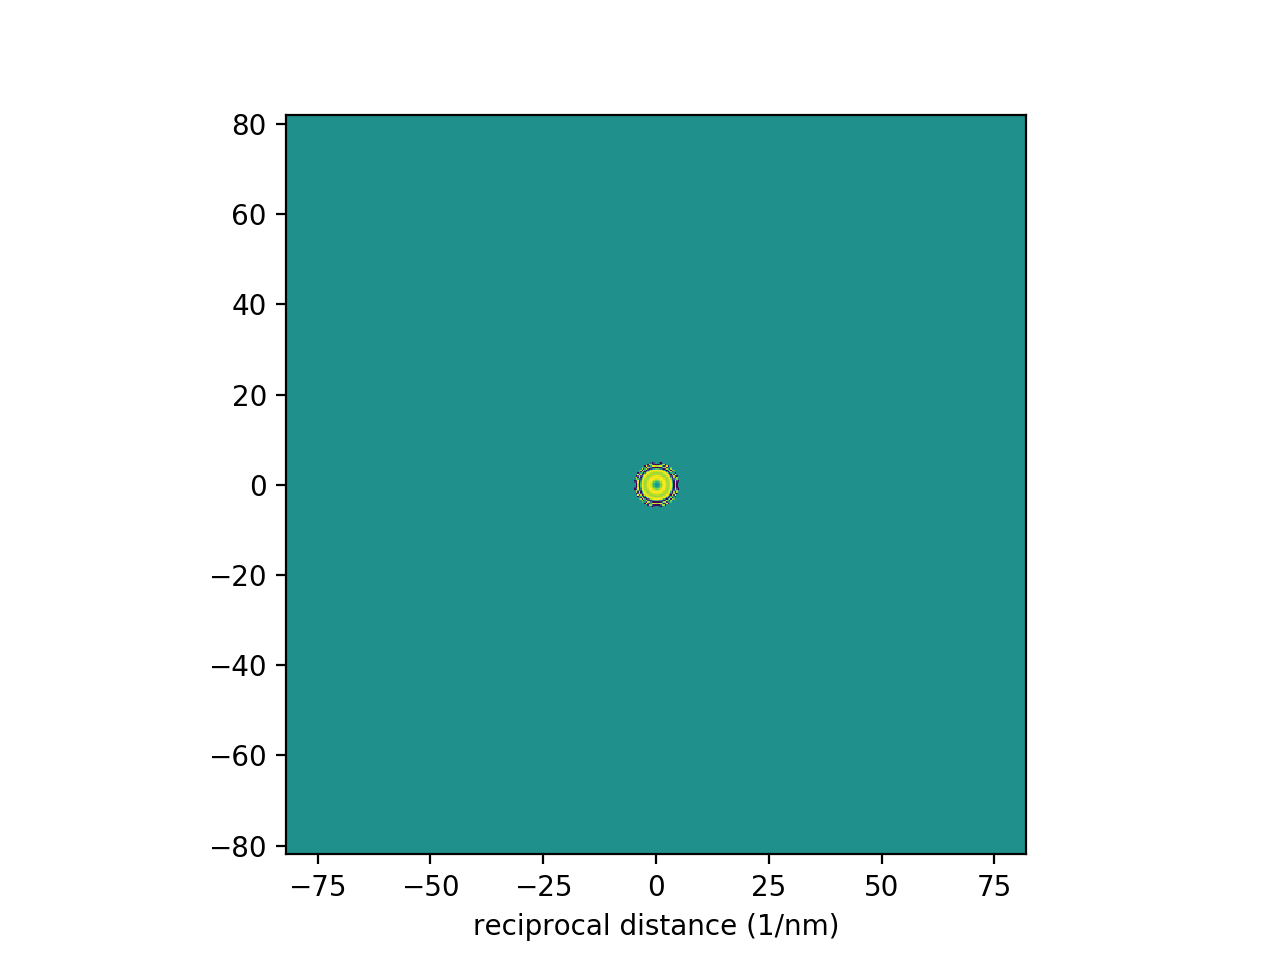

Text(0.5, 0, 'reciprocal distance (1/nm)')

In [7]:
def make_chi(theta, phi, aberrations):
    """Calculate aberration function chi
    
    Input:
    ------
    theta, phi: numpay array (n x m)
        angle meshes of the reciprocal space
    wavelength: float
        wavelength in nm
    ab: dict
        aberrations in nm should at least contain defocus (C10), and spherical abeeration (C30) 
        
    Returns:
    --------
    chi: numpy array (nxm)
        aberration function 
    """
    chi = np.zeros(theta.shape)
    
    for n in range(6):  ## First Sum up to fifth order
        term_first_sum = np.power(theta, n + 1) / (n + 1)  # term in first sum

        second_sum = np.zeros(theta.shape)  ## second Sum intialized with zeros
        for m in range((n + 1) % 2, n + 2, 2):
            if m > 0:
                if f'C{n}{m}a' not in aberrations:  # Set non existent aberrations coefficient to zero
                    aberrations[f'C{n}{m}a'] = 0.
                if f'C{n}{m}b' not in aberrations:
                    aberrations[f'C{n}{m}b'] = 0.

                # term in second sum
                second_sum = second_sum + aberrations[f'C{n}{m}a'] * np.cos(m * phi) \
                                        + aberrations[f'C{n}{m}b'] * np.sin(m * phi)
            else:
                if f'C{n}{m}' not in aberrations:  # Set non existent aberrations coefficient to zero
                    aberrations[f'C{n}{m}'] = 0.
                    
                # term in second sum
                second_sum = second_sum + aberrations[f'C{n}{m}']
                
                
        
        chi = chi + term_first_sum * second_sum * 2 * np.pi / aberrations['wavelength']

    return chi
                           
def objective_lens_function(ab, nx, ny, field_of_view,  aperture_size=10):
    """Objective len function to be convoluted with exit wave to derive image function
    
    Input:
    ab: dict
        aberrations in nm should at least contain defocus (C10), and spherical abeeration (C30) 
    nx: int
        number of pixel in x direction
    ny: int
        number of pixel in y direction
    field_of_view: float
        field of fiew of potential
    
    aperture_size: float
        aperture size in 1/nm
        
    Returns:
    --------
    object function: numpy array (nx x ny)
    extent: list
    """
    wavelength = ab['wavelength']
    # Reciprocal plane in 1/nm
    dk = 1 / field_of_view
    t_xv, t_yv = np.mgrid[int(-nx/2):int(nx/2),int(-ny/2):int(ny/2)] *dk

    # define reciprocal plane in angles
    phi = np.arctan2(t_yv, t_xv)
    theta = np.arctan2(np.sqrt(t_xv**2 + t_yv**2), 1/wavelength)

    mask = theta < aperture_size * wavelength

    # calculate chi
    chi = make_chi(theta, phi, ab)
    
    extent = [-nx/2*dk, nx/2*dk, -nx/2*dk,nx/2*dk]
    return np.exp(-1j*chi)*mask, extent

acceleration_voltage = 200000
wavelength = ks.get_wavelength(acceleration_voltage)

ab={'C10':-91.0, 'C12a':0.0, 'C12b':0.0, 'C30': 2.2*1e6, 'wavelength': wavelength} # aberrations in nm

objective_lens, extent = objective_lens_function(ab, nx, nx, nx*pixel_size, 1/.2)
plt.figure()
plt.imshow(objective_lens.imag, extent=extent)
plt.xlabel('reciprocal distance (1/nm)')


## Image Simulation in Multislice Algorithm

The effect of the objective lens on the image is just the convolution of the exit-wave function and the objective lens funtion. (In the weak phase approximation it was the exit-wave of a single slice) 

If an aperture selects only the inner smooth part of the objetive function in Scherzer defocus, the image is naively to interpret as the dark parts as the atoms (remember the CTF is negative in that case)

<IPython.core.display.Javascript object>


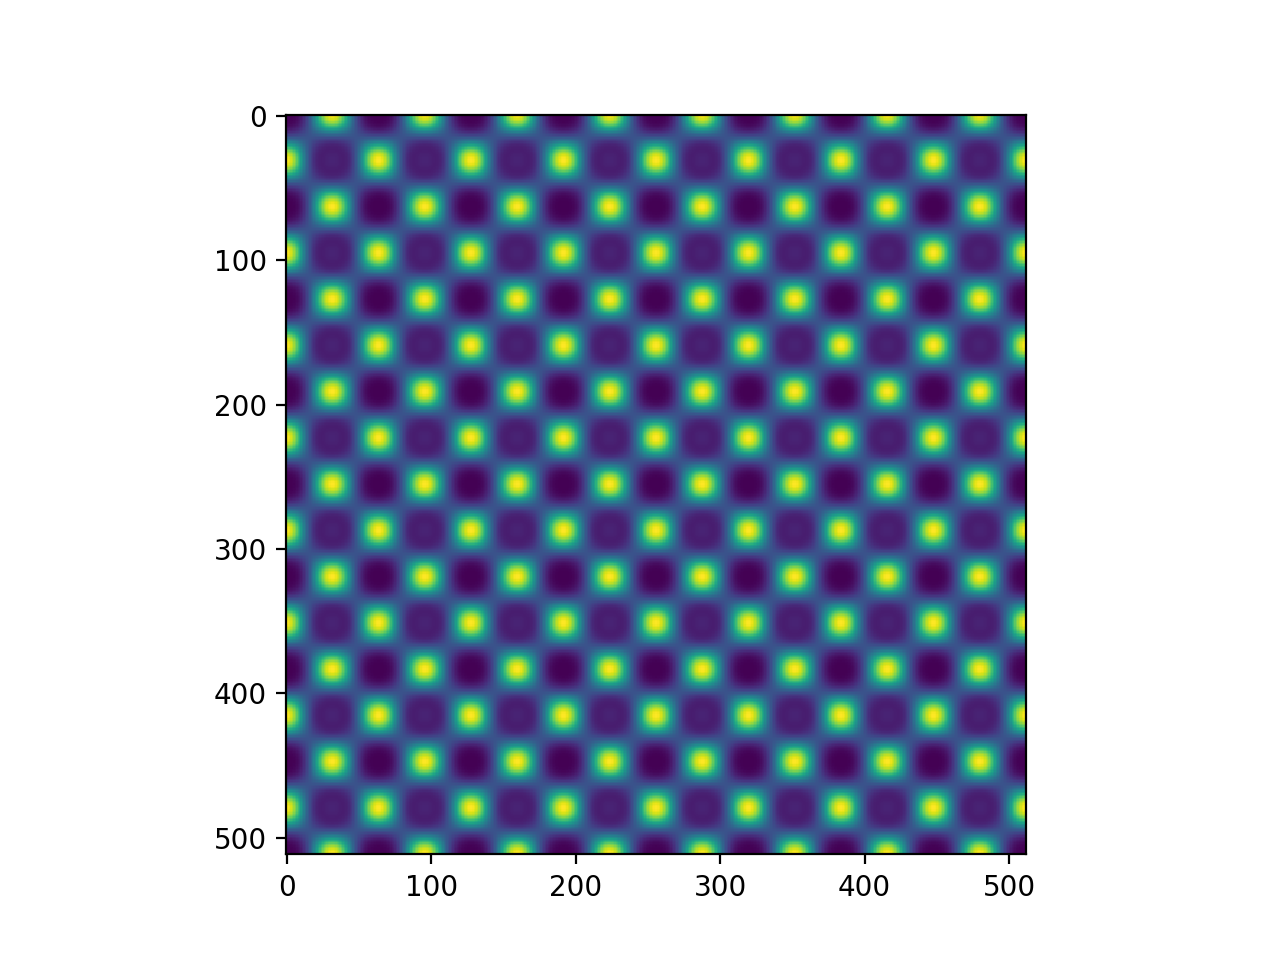

In [9]:
Q_k = np.fft.fft2(exit_wave)

psi_r =  np.fft.fftshift(np.fft.ifft2(np.fft.fft2(exit_wave)*np.fft.fftshift(objective_lens)))

image  = np.abs(psi_r)**2


#image = np.fft.ifft2((np.fft.fft2(exit_wave))*np.fft.fftshift(objective_lens))

plt.figure()

plt.imshow(image)


## Influence of Aberrations on Image

Within this weak phase object aberration, we can already investigate the influence of lens aberrations on the image.

We do now all steps together and check the effect of the aberration, acceleration voltage, aperture, and element onto the final image (in weak phase approximation).



<IPython.core.display.Javascript object>


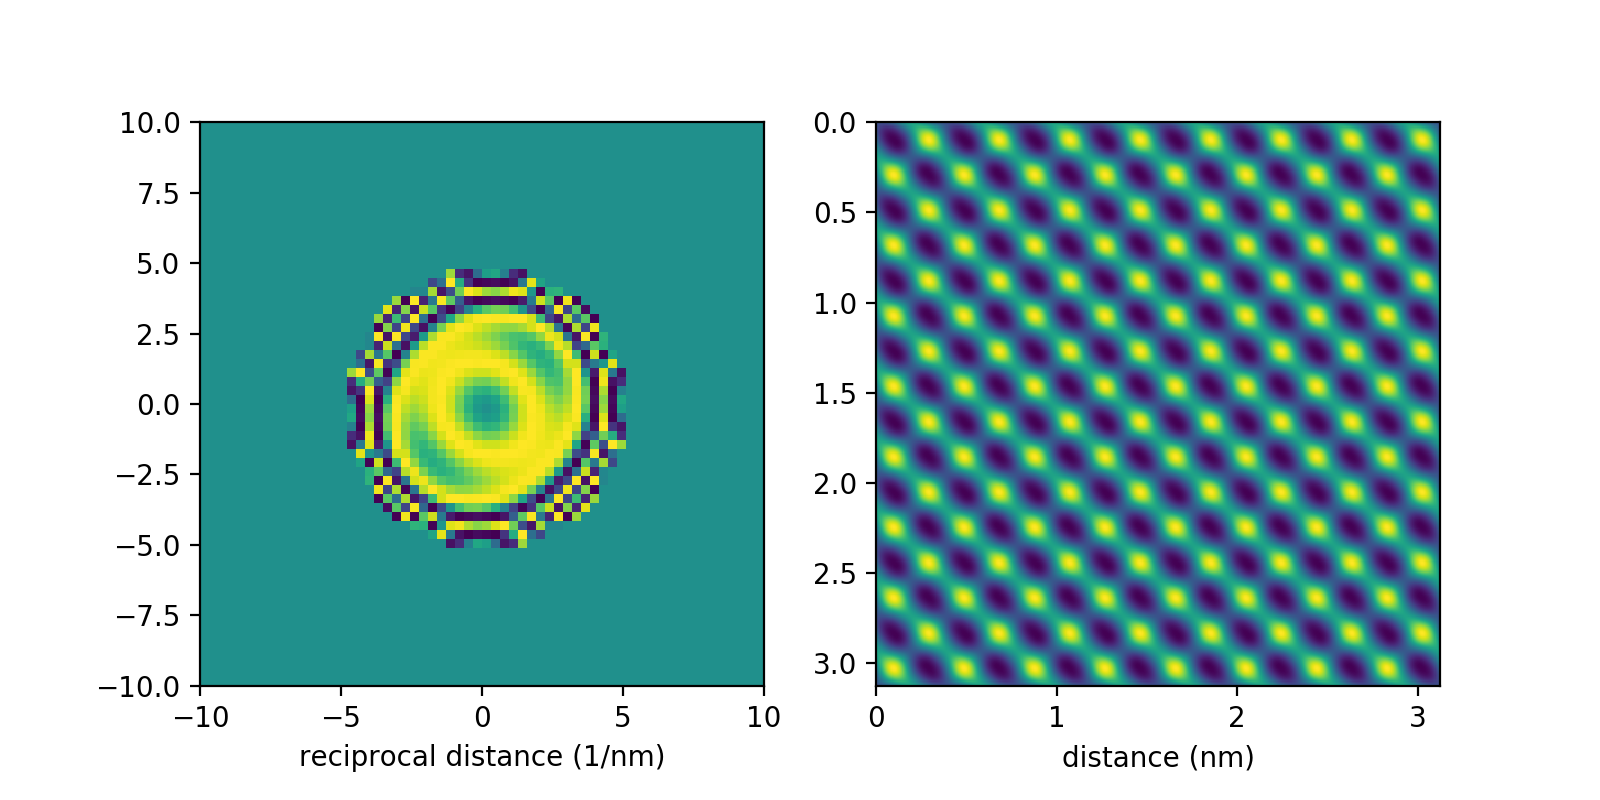

Text(0.5, 0, 'distance (nm)')

In [11]:

acceleration_voltage = 200000
resolution = 0.2
ab={'C10':-91.0, 'C12a': 0.0, 'C12b': 10.0, 'C30': 2.2*1e6, 'wavelength': wavelength} # aberrations in nm

objective_lens, extent_r = objective_lens_function(ab, nx, nx, nx*pixel_size,  1/resolution)

psi_r =  np.fft.fftshift(np.fft.ifft2(np.fft.fft2(exit_wave)*np.fft.fftshift(objective_lens)))

image  = np.abs(psi_r)**2
plt.close('all')
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].imshow(objective_lens.imag, extent=extent_r)
ax[0].set_xlabel('reciprocal distance (1/nm)')
ax[0].set_xlim(-10,10)
ax[0].set_ylim(-10,10)

ax[1].imshow(image, extent=[0,nx*pixel_size, ny*pixel_size, 0 ])
ax[1].set_xlabel('distance (nm)')

### All together

27.31353307037229
Bandwidth limited to a real space resolution of 36.6118875 pm
   (= 68.50 mrad)  for symmetrical anti-aliasing.
Number of symmetrical non-aliasing beams = 91528
simulated SrTiO3 for thickness 19.526 nm


<IPython.core.display.Javascript object>


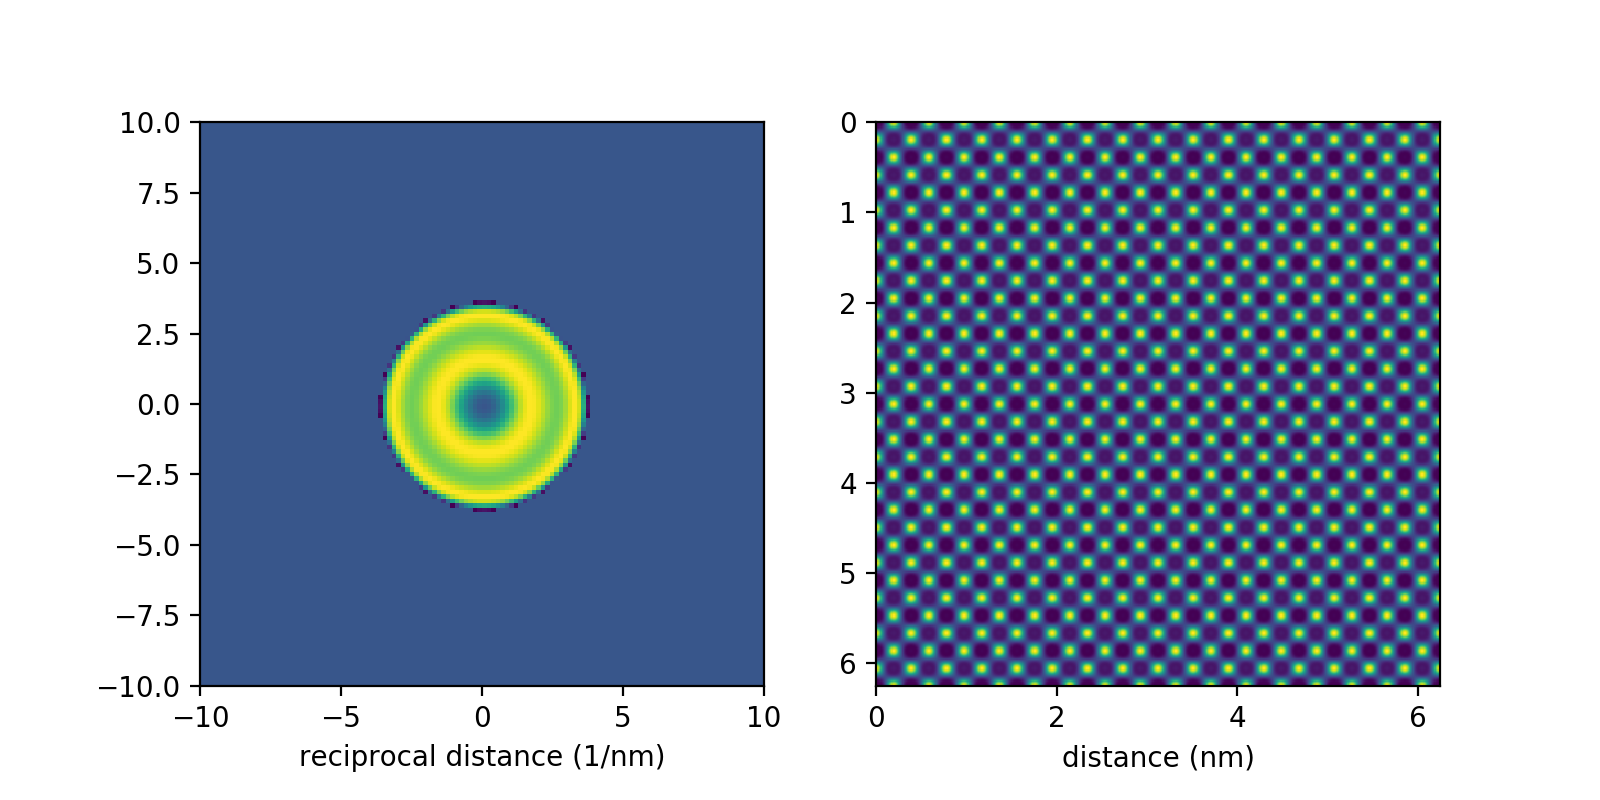

Text(0.5, 0, 'distance (nm)')

In [16]:
# --- input --- 
size_in_pixel = 512
n_cell_x = 16
acceleration_voltage = 200000
number_of_unit_cell_z = 50
resolution = 0.27
ab={'C10':-91.0, 'C12a': 00.0, 'C12b': -0.0, 'C30': 2.2*1e6} # aberrations in nm

# -------------
tags = ks.structure_by_name('SrTiO3')

nx = ny = size_in_pixel
lattice_parameter = a = tags['unit_cell'][0,0]
pixel_size = a/(nx/n_cell_x)

positions = np.dot(tags['base'], tags['unit_cell'])  # in pixel
layers = {}
layers[0] ={0:{'element': 'Sr', 'base': [tags['base'][0, 0:2]]}, 
            1:{'element': 'O',  'base': [tags['base'][3, 0:2]]}}
layers[1] ={0:{'element': 'Ti', 'base': [tags['base'][1, 0:2]]}, 
            1:{'element': 'O',  'base': tags['base'][[2,4], 0:2]}} 


image_extent = [0, size_in_pixel*pixel_size, size_in_pixel*pixel_size,0]
slice_potentials = np.zeros([2,nx,ny])
for layer in layers:
    for atom in layers[layer]:
        elem = layers[layer][atom]['element']
        pos = layers[layer][atom]['base']
        slice_potentials[layer] += ds.potential_2dim(elem, nx, nx, n_cell_x, n_cell_x, a, pos)

transmission = ds.get_transmission(slice_potentials, acceleration_voltage)        

field_of_view = n_cell_x * lattice_parameter
number_layers = len(layers)
delta_z = [tags['unit_cell'][2,2]/number_layers, tags['unit_cell'][2,2]/number_layers]

wavelength = ks.get_wavelength(200000)
ab['wavelength'] = wavelength
bandwidth_factor = 2/3   # Antialiasing bandwidth limit factor
propagator = ds.get_propagator(size_in_pixel, delta_z, number_layers, wavelength, field_of_view, 
                             bandwidth_factor, verbose=True)

recip_FOV = size_in_pixel/field_of_view/2.
reciprocal_extent = [-recip_FOV,recip_FOV,recip_FOV,-recip_FOV]

plane_wave = np.ones([size_in_pixel,size_in_pixel], dtype=complex)
exit_wave = multi_slice(plane_wave, number_of_unit_cell_z, number_layers, transmission, propagator)
    
print(f"simulated {tags['crystal_name']} for thickness {number_of_unit_cell_z*tags['unit_cell'][0,0]:.3f} nm")

wave = np.fft.fft2(exit_wave)
intensity = np.abs(np.fft.fftshift(np.fft.ifft2(wave*wave)))
objective_lens, extent_r = objective_lens_function(ab, nx, nx, nx*pixel_size, 1/resolution)

Q_k = np.fft.fftshift(np.fft.fft2(exit_wave))
psi_r =  np.fft.fftshift(np.fft.ifft2((Q_k*objective_lens)))
image  = np.real(psi_r*np.conjugate(psi_r))

plt.close('all')
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].imshow(objective_lens.imag, extent=extent_r)
ax[0].set_xlabel('reciprocal distance (1/nm)')
ax[0].set_xlim(-10,10)
ax[0].set_ylim(-10,10)

ax[1].imshow(image, extent=[0,nx*pixel_size, ny*pixel_size, 0 ])
ax[1].set_xlabel('distance (nm)')


## Defocus-Thickness Map

The relevant parameters that determine the contrst in an image are 
-sample thickness (dynamic scattering) and 
-defocus (the only lens aberration that can be varied).

A map of defocus thickness will enable you to evaluate your contrast. 

calculating defocus 0 nm
calculating defocus -91 nm
calculating defocus -144 nm
calculating defocus -300 nm


<IPython.core.display.Javascript object>


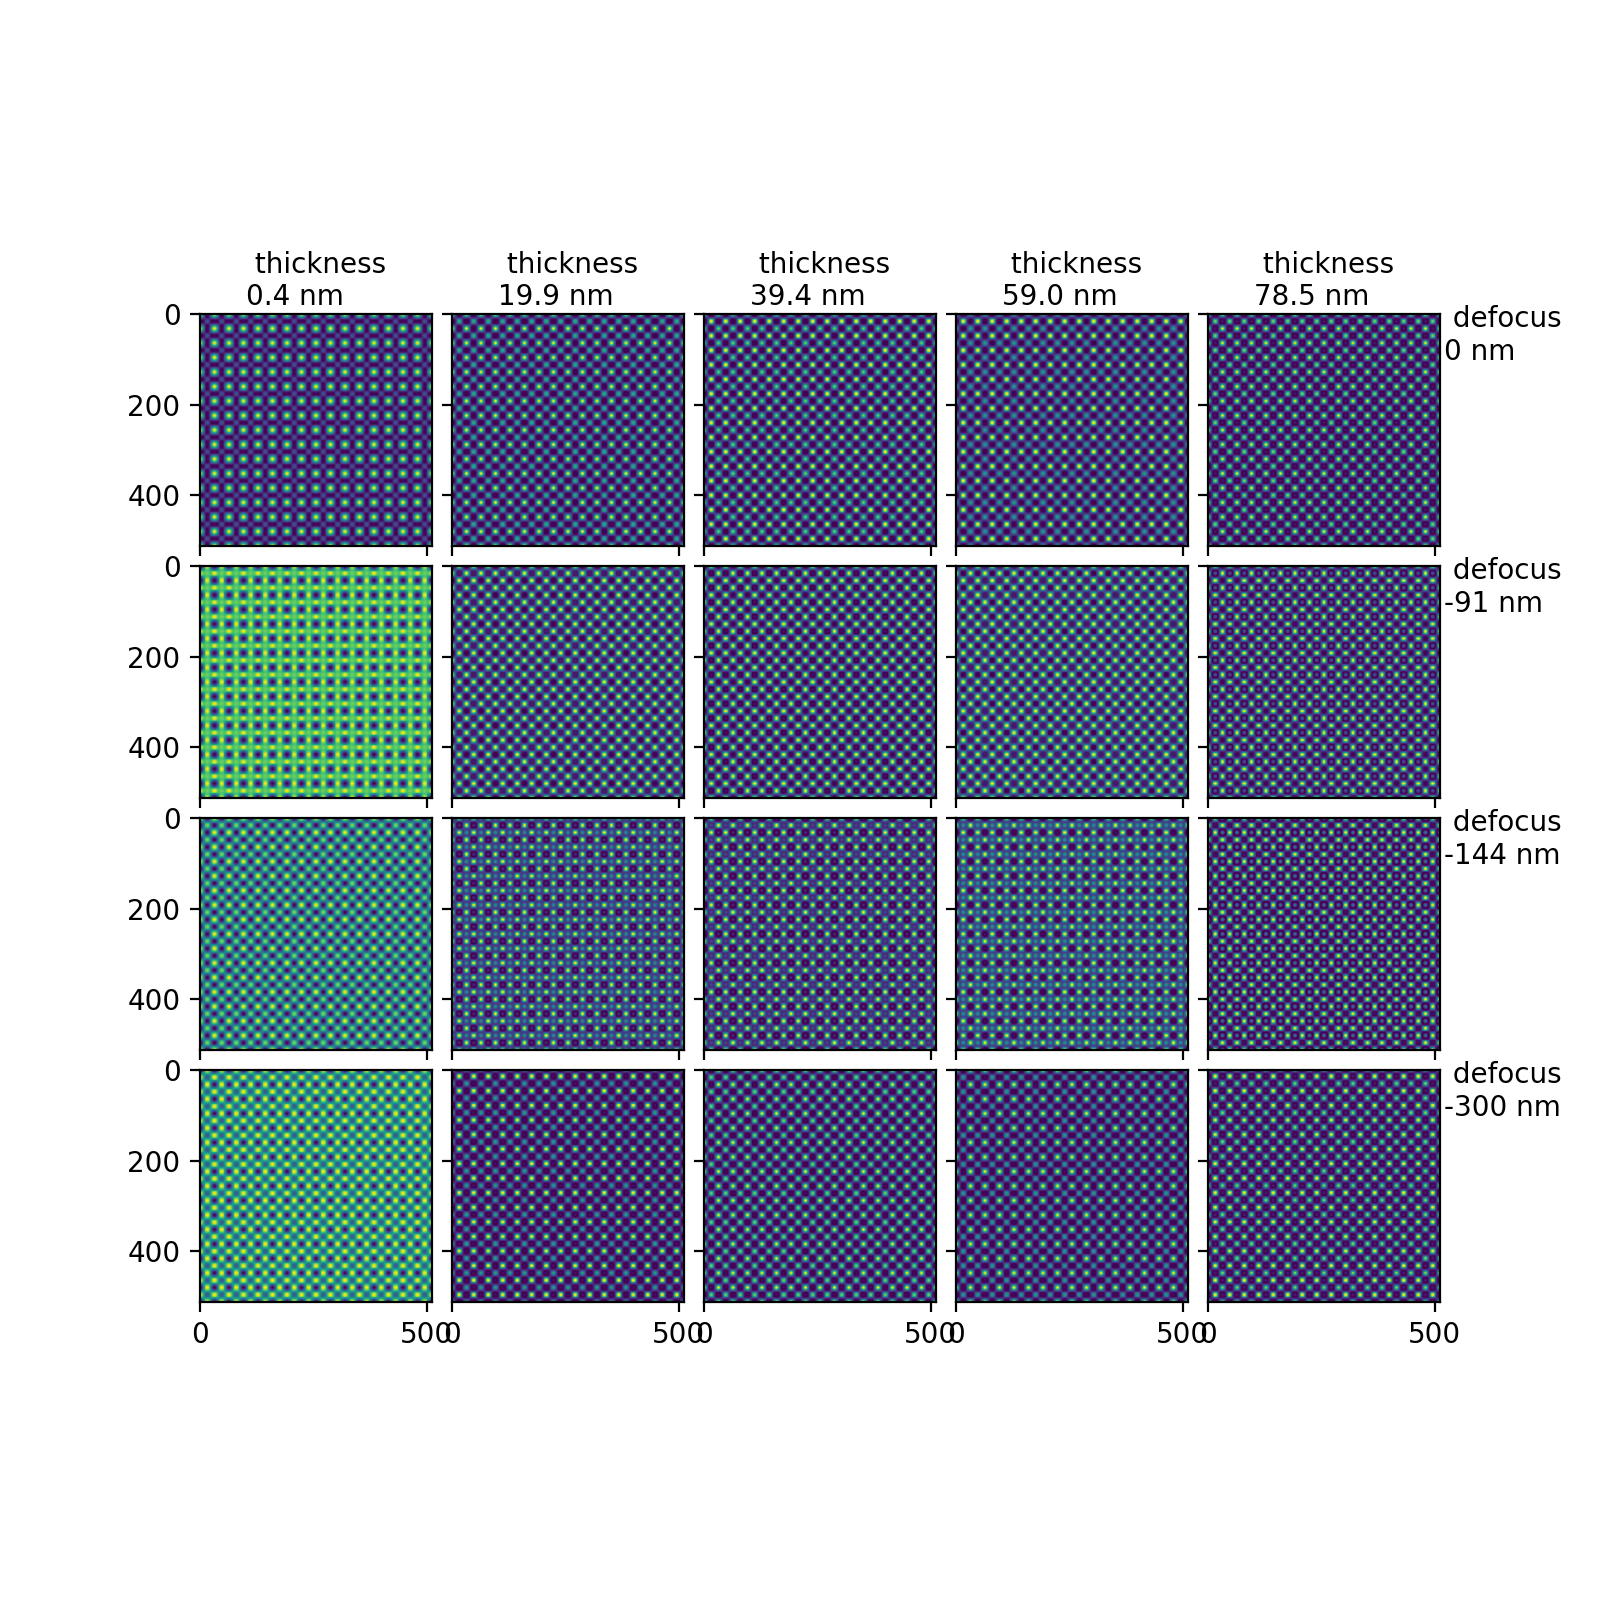

In [17]:

i = 0
defoci = [0, -91,-144, -300]
thickn= [1, 50, 50, 50, 50]
images =  np.zeros((len(defoci), len(thickn), nx, nx))

for defocus in defoci:
    ab['C10'] = defocus
    print(f'calculating defocus {defocus} nm')
    objective_lens, extent_r = objective_lens_function(ab, nx, nx, nx*pixel_size,  1/resolution)
    plane_wave = np.ones([size_in_pixel,size_in_pixel], dtype=complex)
    incident_wave = plane_wave
    j = 0
    for number_of_unit_cell_z in thickn:
        exit_wave = multi_slice(incident_wave, number_of_unit_cell_z, number_layers, transmission, propagator)
        
        objective_lens, extent_r = objective_lens_function(ab, nx, nx, nx*pixel_size,  1/resolution)

        Q_k = np.fft.fftshift(np.fft.fft2(exit_wave))
        psi_r =  np.fft.fftshift(np.fft.ifft2((Q_k*objective_lens)))
        images[i,j]  = np.real(psi_r*np.conjugate(psi_r))
        incident_wave = exit_wave  # resue exit wave as incident wave
        
        j+=1
    i+=1
    

fig = plt.figure(figsize=(8., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=( len(defoci), len(thickn)),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for i in range(len(defoci)):
    for j in range(len(thickn)):
        grid[i*len(thickn)+j].imshow(np.abs(images[i,j]))
for i in range(len(defoci)):
    grid[i*len(thickn)+len(thickn)-1].text(520,100,f' defocus \n{defoci[i]} nm')
th = 0
for j in range(len(thickn)):
    th += thickn[j]* a
    grid[j].text(100,-20,f' thickness \n{th:.1f} nm')
        

### Zooming in 

Look at the top left corner (the position of the Sr atomic column) and observe contrast reversal with thickness and defocus.

<IPython.core.display.Javascript object>


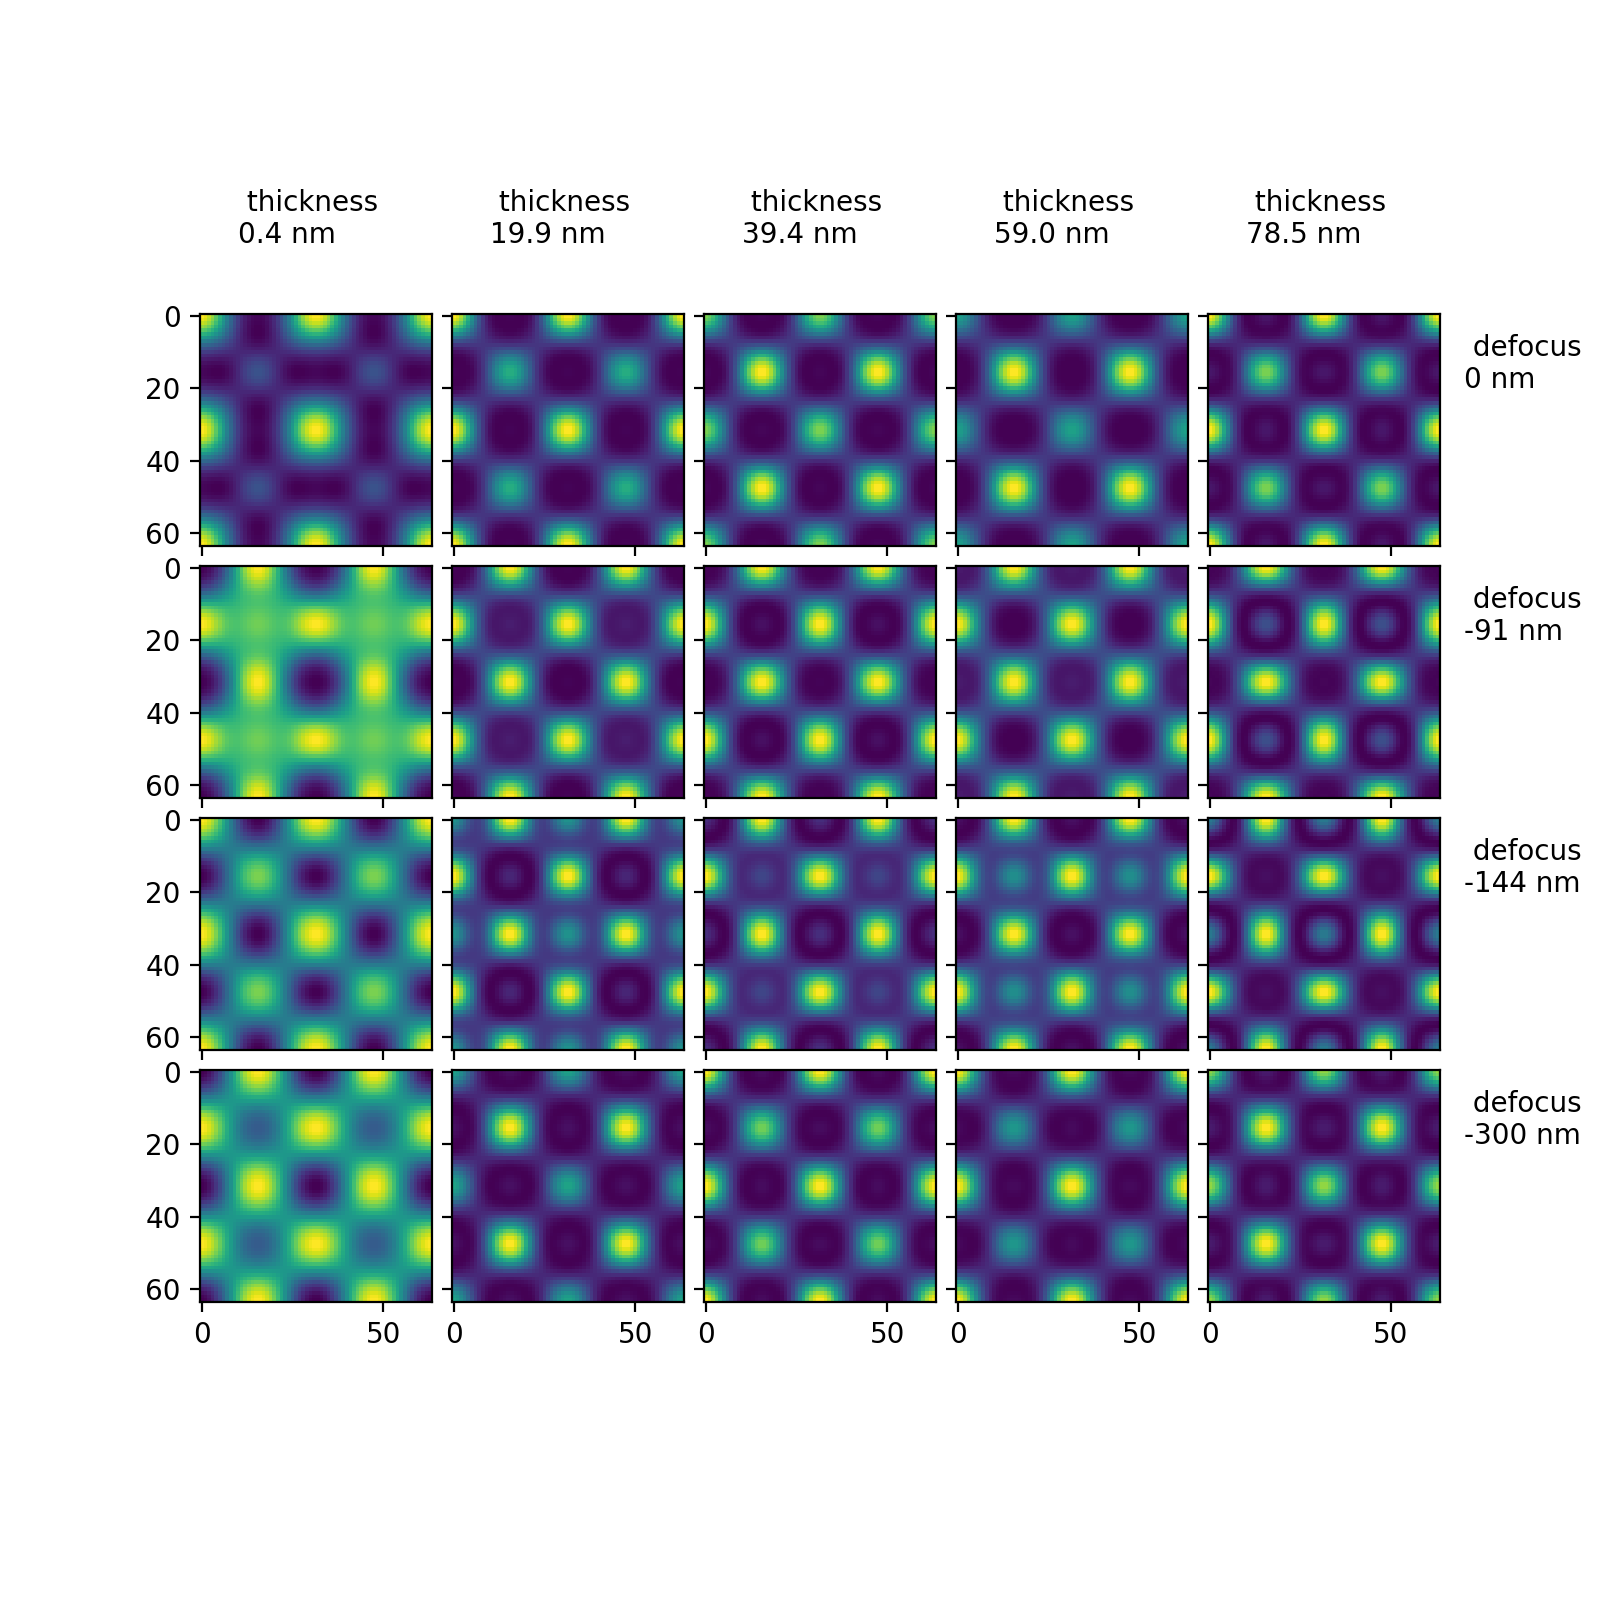

In [18]:
fig = plt.figure(figsize=(8., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=( len(defoci), len(thickn)),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for i in range(len(defoci)):
    for j in range(len(thickn)):        
        grid[i*len(thickn)+j].imshow(np.abs(images[i,j, 0:64, 0:64]))
for i in range(len(defoci)):
    grid[i*len(thickn)+len(thickn)-1].text(70,20,f' defocus \n{defoci[i]} nm')
th = 0
for j in range(len(thickn)):
    th += thickn[j]* a
    grid[j].text(10,-20,f' thickness \n{th:.1f} nm')
        

## Summary

For a quantitative image simulation we need to do dynamic scattering theory. 

The dynamic scattering theory is done within the multislice algorithm that treats each slice like a weak phase object.

When doing phase-contrast high-resolution imaging you should always have a ``defocus-thickness map`` with you to establish microscopy parameters and evaluate contrast in images of crystals.
>
> The higher order Scherzer defoci will give you a good idea about how much the defoci should change.
>

We have not yet implemented the thermal diffuse scattering: scattering on phonons. 
We will include this effect in the Z-contrast imaging part
